In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# загружаем bboxes.csv

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('Пользователь загрузил файл "{name}" длиной {length} байт.'.format(name=fn, length=len(uploaded[fn])))

Saving bboxes.csv to bboxes.csv
Пользователь загрузил файл "bboxes.csv" длиной 13445718 байт.


In [ ]:
import os
import sys
import numpy as np
import tensorflow as tf
import random
import math
import warnings
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras import layers

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 19
random.seed = seed
np.random.seed = seed

In [ ]:
# распакуем набор данных
!unzip '/content/drive/MyDrive/colab_datasests/data-science-bowl-2018.zip' -d data_science_bowl_2018

Archive:  /content/drive/MyDrive/colab_datasests/data-science-bowl-2018.zip
  inflating: data_science_bowl_2018/stage1_sample_submission.csv.zip  
  inflating: data_science_bowl_2018/stage1_solution.csv.zip  
  inflating: data_science_bowl_2018/stage1_test.zip  
  inflating: data_science_bowl_2018/stage1_train.zip  
  inflating: data_science_bowl_2018/stage1_train_labels.csv.zip  
  inflating: data_science_bowl_2018/stage2_sample_submission_final.csv.zip  
  inflating: data_science_bowl_2018/stage2_test_final.zip  


In [ ]:
# тестовый набор данных
!unzip '/content/data_science_bowl_2018/stage1_test' -d '/content/data_science_bowl_2018/stage1_test'

Archive:  /content/data_science_bowl_2018/stage1_test.zip
   creating: /content/data_science_bowl_2018/stage1_test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/
   creating: /content/data_science_bowl_2018/stage1_test/0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac/
   creating: /content/data_science_bowl_2018/stage1_test/0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732/
   creating: /content/data_science_bowl_2018/stage1_test/0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925/
   creating: /content/data_science_bowl_2018/stage1_test/0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6/
   creating: /content/data_science_bowl_2018/stage1_test/0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466/
   creating: /content/data_science_bowl_2018/stage1_test/1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c/
   creating: /content/data_science_bowl_2018/stage1_test/17b9bf4356db24967c4677b8

In [ ]:
# обучающий набор данных
!unzip '/content/data_science_bowl_2018/stage1_train' -d '/content/data_science_bowl_2018/stage1_train'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/data_science_bowl_2018/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: /content/data_science_bowl_2018/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: /content/data_science_bowl_2018/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: /content/data_science_bowl_2018/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: /content/data_science_bowl_2018/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b

In [ ]:
# задаем константы
IMG_WIDTH = 384
IMG_HEIGHT = 384
IMG_CHANNELS = 3

TRAIN_PATH = '/content/data_science_bowl_2018/stage1_train'
TEST_PATH = '/content/data_science_bowl_2018/stage1_test'

In [ ]:
# получаем подпапки в TRAIN_PATH и TEST_PATH
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# создаем массивы для хранения изображений
# форма массивов --> (количество изображений, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [ ]:
# Изменим размер обучающих изображений
print('изменение размера обучающих изображений... ')
sys.stdout.flush() # принудительно очищает буфер

# перебираем подпапки train и изменяем размер
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    train_images[n] = img

# получим и Изменим размер тестовых изображений
sizes_test = []
print('\nизменение размера тестовых изображений ... ')
sys.stdout.flush()

# перебираем подпапки test и изменяем размер
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('\nГотово!')

изменение размера обучающих изображений... 


100%|██████████| 670/670 [00:43<00:00, 15.25it/s]


изменение размера тестовых изображений ... 



100%|██████████| 65/65 [00:05<00:00, 11.37it/s]


Готово!


In [ ]:
# Учитывая изображение маски, идентификатор обучающего изображения, идентификатор
# маски и идентификатор вращения (от 0 до 3), мы генерируем метки истинной информации

def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    # используем OpenCV для поиска ограничивающей рамки объектов в изображениях масок.
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]

    # Получаем координаты ограничивающего прямоугольника
    x, y, w, h = cv2.boundingRect(cnt)

    # Регулируем координаты в зависимости от формы и размера изображения
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])

    # проверяем, что координаты ограничивающего прямоугольника находятся в пределах границ изображения
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y

    # словарь для хранения координат ограничивающего прямоугольника и связанных идентификаторов
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict

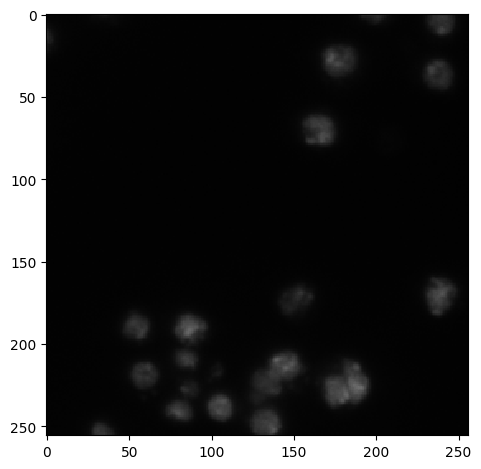

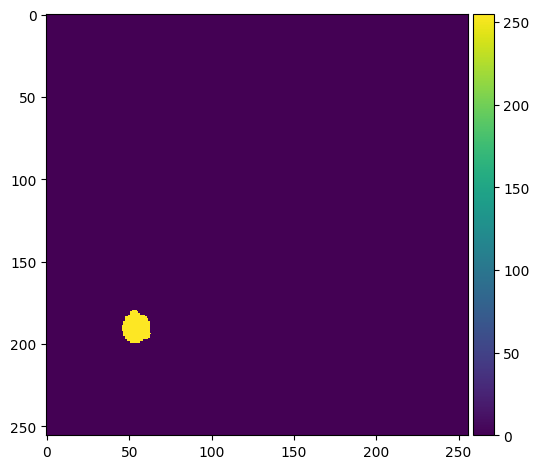

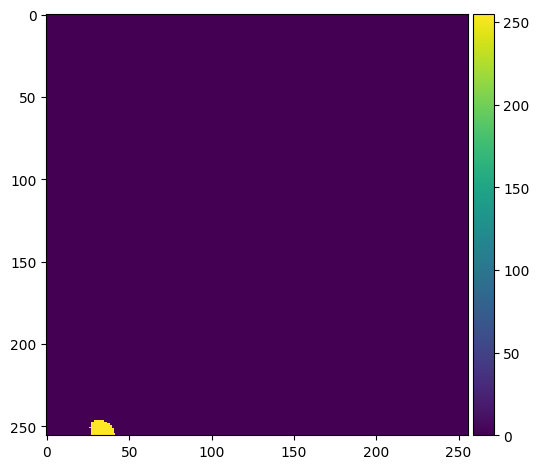

In [ ]:
# примре изображения
img = imread("/content/data_science_bowl_2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png")
plt.figure()
imshow(img)

# маска одного из объектов
maskImg = imread("/content/data_science_bowl_2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png")
plt.figure()
imshow(maskImg)

# маска еще одного из объектов
maskImg = imread("/content/data_science_bowl_2018/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png")
plt.figure()
imshow(maskImg)


In [ ]:
# Создать ограничивающую рамку (метки) базовой истины.
# Метки основаны на файлах масок, включенных в набор обучающих данных.
# Файлы масок — это изображения, показывающие объекты на обучающих изображениях.

path_bboxes_csv = "/content/bboxes.csv"

# Проверяем, существует ли файл
if not os.path.isfile(path_bboxes_csv):
    # Если файла не существует, создаем новый DataFrame
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1

    # Перебираем подпапки train и заполняем DataFrame
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + "/" + id_
        for mask_id, mask_file in enumerate(next(os.walk(path + '/masks/'))[2]):
            mask_ = imread(path + '/masks/' + mask_file)
            # Чтобы расширить набор обучающих данных, мы вращаем данные маски
            for r in range(4):
                # Сохраняем ограничивающие рамки в DataFrame
                bboxes.loc[row_count] = store_bounding_boxes(np.rot90(mask_, r), id_, mask_id, r)
                row_count += 1

    # Сохраняем DataFrame в файл CSV
    bboxes.to_csv(path_bboxes_csv, index=False)
else:
    # Если файл существует, считывает данные из CSV-файла в DataFrame
    bboxes = pd.read_csv(path_bboxes_csv)

In [ ]:
# Определяем размер ячейки сетки
GRID_DIM = 12
# Ширина/высота сетки в пикселях
GRID_PIX = IMG_WIDTH//GRID_DIM

BATCH_SIZE = 14

In [ ]:
# Создаем новый DataFrame с двумя столбцами
train_ids_df = pd.DataFrame(columns=["idx", "id_"])
cnt = 0

# Перебираем подпапки train и добавляем новую строку в DataFrame для каждого идентификатора
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_ids_df.loc[cnt] = { "idx": n, "id_": id_}
    cnt += 1

# Установливаем индекс DataFrame в столбец idx
train_ids_df = train_ids_df.set_index(['idx'])

100%|██████████| 670/670 [00:01<00:00, 541.63it/s]


In [ ]:
# Координаты коробки на основе сетки (левый верхний угол)
bboxes['grid_row'] = bboxes['y']//GRID_PIX
bboxes['grid_column'] = bboxes['x']//GRID_PIX

# Координаты центра сетки, в которой расположен этот блок
bboxes['grid_center_x'] = bboxes['grid_column'] * GRID_PIX + GRID_PIX/2
bboxes['grid_center_y'] = bboxes['grid_row'] * GRID_PIX + GRID_PIX/2

# Координаты центра поля
bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(IMG_WIDTH)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(IMG_HEIGHT)

bboxes['new_w'] = np.sqrt(bboxes.w/(IMG_WIDTH))
bboxes['new_h'] = np.sqrt(bboxes.h/(IMG_WIDTH))

# Здесь есть известный нам объект. Поэтому установим достоверность объекта на 1.
bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h

In [ ]:
mask_count = 1

#Установите максимальное количество ограничивающих рамок, разрешенных для каждой ячейки сетки
MAX_BB_CNT = 2

In [ ]:
# Возвращает метку для данного идентификатора обучающего изображения и идентификатора вращения
def get_grid_info(tr_id, rotby_90):
    # Фильтруем DataFrame на основе заданных значений train_id и rotby_90
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    # Удаляем ненужные столбцы
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    # Сортируем DataFrame по Grid_column, Grid_row и Box_area в порядке убывания
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)

    global mask_count
    mask_count += len(df)

    # Инициализируем тензор истинности метки
    label_info = np.zeros(shape=(GRID_DIM, GRID_DIM, MAX_BB_CNT, 5),  dtype=np.float32) + 0.000001

    # Перебираем строки DataFrame
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        # Перебираем поля в текущей ячейке сетки
        for b in range(MAX_BB_CNT):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break

    # Возвращаем тензор истинности метки
    return label_info

In [ ]:
# Возвращает значение label ground true для входных данных.
# Размерность равна (размер пакета, ширина сетки, высота сетки, прогнозируемые поля в ячейке, переменные в поле).
def get_labels(counts, rotations):
    grid_info = np.zeros(shape=(BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5), dtype=np.float32)

    # Перебираем счетчики и вращения и вызываем функцию get_grid_info для каждого из них
    for i, c in enumerate(counts):
        tr_id = train_ids_df.loc[c, 'id_']
        grid_info[i] = get_grid_info(tr_id, rotations[i])

    grid_info = np.reshape(grid_info, newshape=[BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])

    # Возвращаем измененный массив Grid_info
    return grid_info

In [ ]:
def get_images(counts, rotations):
    images = np.zeros(shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)

    # Перебираем счетчики и вращения и вызываем функцию np.rot90 для каждого из них
    for i, c in enumerate(counts):
        images[i] = np.rot90(train_images[c], rotations[i])

    # Возвращаем массив изображений
    return images

In [ ]:
def next_batch():
    rotations = []
    rand_counts = []

    # Перебираем диапазон размера пакета
    for i in range(BATCH_SIZE):
        rotations.append(random.randint(0, 3))
        rand_counts.append(random.randint(0, 669))

    # Вызовите функции get_images и get_labels с rand_counts и поворотами в качестве аргументов
    return get_images(rand_counts, rotations), get_labels(rand_counts, rotations)

In [ ]:
tf.compat.v1.disable_eager_execution()
# Сбросьте default graph, чтобы избежать конфликтов с другими графиками.
tf.compat.v1.reset_default_graph()

# Входные данные: ширина изображения x высота изображения x 3 размера цвета.
X = tf.compat.v1.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, 3])
# Вывод: сетка * сетка * ограничивающая рамка на ячейку * 5 переменных (x, y, w, h, достоверность объекта)
Y_ = tf.compat.v1.placeholder(tf.float32, [None, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
lr = tf.compat.v1.placeholder(tf.float32)

In [ ]:
# Логиты: окончательный результат последнего сверточного слоя.
def process_logits(logits, name=None):
    net = tf.reshape(logits, [-1, GRID_DIM*1, GRID_DIM*1, MAX_BB_CNT*5*16, 1])

    # Каждый предсказанный блок имеет только 5 переменных. Итак, возьмем среднее значение среди значений 5*16.
    net = tf.keras.layers.AveragePooling3D([1, 1, 16], [1, 1, 16], padding="valid")(net)

    # Каждая ячейка имеет 5 выходных значений: (x, y, w, h, достоверность объекта).
    net = tf.reshape(net, [-1, GRID_DIM*GRID_DIM*MAX_BB_CNT, 5]) #GRID_DIM = 12

    # Транспонируем тензор.
    net = tf.transpose(net, [1, 2, 0])

    logits_tensor = tf.map_fn(lambda x:
                            tf.stack([
                                tf.tanh(x[0]),
                                tf.tanh(x[1]),
                                tf.sqrt(tf.sigmoid(x[2])),
                                tf.sqrt(tf.sigmoid(x[3])),
                                tf.sigmoid(x[4])
                            ]), net)

    logits_tensor = tf.transpose(logits_tensor, [2, 0, 1])
    logits_tensor = tf.reshape(logits_tensor, [-1, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])

    return logits_tensor

In [ ]:
# Рассчитаем стоимость потерь модели.
def normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj):
    # Разница между метками основной истины и предсказанными блоками.
    yolo_loss = tf.reduce_sum(tf.math.squared_difference(labels, processed_logits), axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)

    # Прогноз координат (x, y) умножается на заданный вес: лямбда_коорды.
    # Прогноз (достоверность объекта) умножает другой заданный вес: лямбда_noobj.
    yolo_loss = tf.stack([tf.multiply(lambda_coords, yolo_loss[0]),
                          tf.multiply(lambda_coords, yolo_loss[1]),
                          yolo_loss[2],
                          yolo_loss[3],
                          tf.multiply(lambda_noobj,yolo_loss[4])])
    yolo_loss = tf.reduce_sum(yolo_loss)

    return  yolo_loss

In [ ]:
def l_relu(features):
    return tf.nn.leaky_relu(features, 0.1)

In [ ]:
# Определяет слой сжатия, который имеет только фильтры 1x1.
def squeeze_module(x, dim, idx):
    name = 'conv_' + idx + '_sq'
    return tf.keras.layers.Conv2D(filters=dim, kernel_size=1, strides=1, padding="same",
                           activation=l_relu, name=name)(x)

# Определяет расширенный слой, который содержит смесь фильтров 1x1 и 3x3.
def expand_module(x, dim, idx):
    name = 'conv_' + idx + '_ex_' + '0'
    net1 = tf.keras.layers.Conv2D(filters=dim, kernel_size=1, strides=1, padding="same",
                           activation=l_relu, name=name)(x)

    name = 'conv_' + idx + '_ex_' + '1'
    net2 = tf.keras.layers.Conv2D(filters=dim, kernel_size=3, strides=1, padding="same",
                           activation=l_relu, name=name)(x)

    return tf.concat([net1, net2], 3)

In [ ]:
# Модуль Fire состоит из слоя сжатия и слоя расширения.
def fire_module(input_tensor, squeeze_dim, expand_dim, idx):
    net = squeeze_module(input_tensor, squeeze_dim, idx)
    net = expand_module(net, expand_dim, idx)
    return net

In [ ]:
# SqueezeNet

net = tf.keras.layers.Conv2D(filters=32, kernel_size=1, strides=1, padding="same",
                       activation=l_relu, name='conv0')(X) #384

net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")(net) #192

net = fire_module(net, 32, 64, '0')
net = fire_module(net, 32, 64, '1')
net = fire_module(net, 32, 64, '2')

net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")(net) #96


net = fire_module(net, 64, 96, '3')
net = fire_module(net, 64, 96, '4')
net = fire_module(net, 64, 96, '5')


net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")(net) #48

net = fire_module(net, 128, 160, '6')
net = fire_module(net, 128, 160, '7')
net = fire_module(net, 128, 128, '8')


net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")(net) #24

net = fire_module(net, 256, 512, '9')
net = fire_module(net, 256, 512, '10')
net = fire_module(net, 256, 512, '11')

net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")(net) #12

net = fire_module(net, 512, 1024, '12')
net = fire_module(net, 512, 1024, '13')
net = fire_module(net, 512, 1024, '14')

# Последний конв-слой.
# Номера фильтров: (количество предсказанных блоков на ячейку) * (переменные на блок) * 16
logits = tf.keras.layers.Conv2D(filters=MAX_BB_CNT*5*16, kernel_size=1, strides=1, padding="same",
                       activation=None, name='conv40')(net) #12

# Обрабатываем логиты
processed_logits = process_logits(logits)

# Устанавливаем метки
labels = Y_

# Устанавливаем константы для функции потерь
lambda_coords = tf.constant(5.0)
lambda_noobj = tf.constant(0.5)

# Рассчитать потерю YOLO
yolo_loss = normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj)

# Определить операцию обучения
train_op = tf.compat.v1.train.AdamOptimizer(lr).minimize(yolo_loss)

In [ ]:
# значение True - обучить модель с нуля, и значение False - использовать предварительно обученную модель
start_training = True

# Если start_training имеет значение False, загрузите предварительно обученную модель
# if not start_training:
#     test_image_id = 33
#     saver = tf.train.Saver()
#     with tf.Session() as sess:
#         saver.restore(sess, "./models/pre-trained-model/model.ckpt")
#         result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

In [ ]:
# Отключаем активное выполнение для совместимости с Keras и TensorFlow
tf.compat.v1.disable_eager_execution()

# Цикл обучения
if(start_training):
    # Инициализируем глобальные переменные
    init = tf.compat.v1.global_variables_initializer()
    # Создаем сеанс
    sess = tf.compat.v1.Session()
    sess.run(init)

    # Инициализируем счетчики
    batch_count = 0
    display_count = 1
    global mask_count

    # перебираем пакеты
    for i in range(2500):
        batch_X, batch_Y = next_batch()
        batch_count += 1

        # Запускаем сеанс для обучения
        train_loss, _ = sess.run([yolo_loss, train_op], {X: batch_X, Y_: batch_Y, lr: 0.0001})

        # Выводить потери при обучении каждые 100 итераций
        if(i % 100 == 0):
            print(str(display_count) + " training loss(" + str(mask_count) + "): " + str(train_loss))
            display_count +=1
        mask_count = 0

    print("Готово!")

1 training loss(1477): 4277.4033
2 training loss(662): 330.19672


In [ ]:
if(start_training):
    # Выбираем ID тестового изображения
    test_image_id = 10
    # Запускаем сессию и получаем обработанные логиты для указанного изображения
    result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

In [ ]:
boxes = result[0]
# Печатаем форму полученных боксов
print(boxes.shape)

# Преобразуем форму боксов к нужной размерности
boxes = np.reshape(boxes, newshape=[GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
bbs = []

# Проходим по каждому сегменту сетки
for i in range(GRID_DIM):
    for j in range(GRID_DIM):
        for b in range(MAX_BB_CNT):
            # Если уверенность бокса больше 0.1, обрабатываем
            if(boxes[i][j][b][4]> 0.1):
                grid_center_x = ((j+0)*GRID_PIX + GRID_PIX/2)
                grid_center_y = ((i+0)*GRID_PIX + GRID_PIX/2)

                # Вычисляем координаты центра бокса относительно всего изображения
                new_box_center_x = boxes[i][j][b][0] * IMG_WIDTH + grid_center_x
                new_box_center_y = boxes[i][j][b][1] * IMG_HEIGHT + grid_center_y

                # Вычисляем новую ширину и высоту бокса
                new_w = np.square(boxes[i][j][b][2]) * IMG_WIDTH
                new_h = np.square(boxes[i][j][b][3]) * IMG_HEIGHT

                # Вычисляем координаты краев бокса
                x1 = new_box_center_x - new_w/2
                y1 = new_box_center_y - new_h/2

                x2 = new_box_center_x + new_w/2
                y2 = new_box_center_y + new_h/2

                # Добавляем координаты в список bbs
                bbs.append((math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)))

(1, 12, 12, 2, 5)


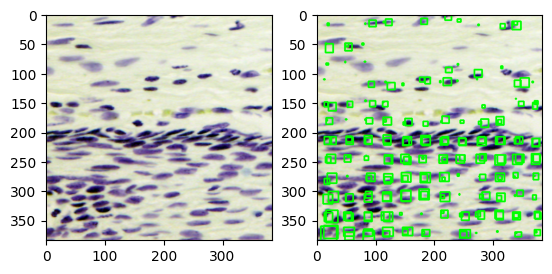

In [ ]:
# Получаем тестовое изображение
img = test_images[test_image_id]
f, axs = plt.subplots(1,2)
axs[0].imshow(img)

# Создаем копию изображения с боксами
img_withbbox = np.copy(img)
for i, b in enumerate(bbs):
    # Рисуем прямоугольники вокруг объектов
    cv2.rectangle(img_withbbox,(b[0], b[1]),(b[2], b[3]),(0,255,0),2)

# Отображаем изображение с боксами
axs[1].imshow(img_withbbox)